In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

from matminer.utils.conversions import str_to_composition
from matminer.featurizers.composition import ElementProperty

In [16]:
# Retrieve NIST SCD dataset from Citrine using matminer.
# The data will be stored in the df DataFrame.

first_retrieve = True #change it to indicate first time retrieve dataset or not

from matminer.data_retrieval.retrieve_Citrine import CitrineDataRetrieval
from os import environ

if first_retrieve:

    api_key = environ['CITRINATION_API_KEY'] # insert your api key here
    c = CitrineDataRetrieval(api_key=api_key)
    df = c.get_dataframe(criteria={'data_set_id': '151803'})
    
    # Save downloaded dataset
    df.to_csv('NIST_CeramicDataSet.csv')
    df.to_pickle('NIST_CeramicDataSet.pkl')
else:
    df  = pd.read_pickle('NIST_CeramicDataSet.pkl')

100%|██████████████████████████████████████| 4098/4098 [02:02<00:00, 33.36it/s]


all available fields:
['Grinding Rat-conditions', 'Weibull Modulus-conditions', 'Poissons Ratio-minimum', 'Log Wear Coefficient-conditions', 'Creep Activatn Energy', 'Gruneisen Parameter', 'Debye Temperature', 'Sintering Aid-conditions', 'Thermal Expansion-conditions', 'Dopant-conditions', 'Electrical Resistivity Log', 'Tensile Strength', 'Weibull Modulus', 'Axis Length-conditions', 'Tensile Strength-maximum', 'Thermal Expansion', 'Melting Point Temperature', 'Chemical Family', 'Sound Velocity-units', 'Elasticity Tensor', 'Electrical Resistivity Log-conditions', 'Fracture Toughness-maximum', 'Porosity-conditions', 'Fracture Energy-units', 'Porosity-units', 'Hardness-units', 'Friction Coefficient-minimum', 'Weibull Strength-conditions', 'Flexural Strength-conditions', 'Fracture Toughness-conditions', 'Relative Atomic Coordinate-conditions', 'Thermal Conductivity', 'Shear Modulus-conditions', 'Flexural Strength-maximum', 'Creep Rate-conditions', 'Diffusion Coefficient', 'SMILES', 'Weibul

In [22]:
# Get the number of samples and number of features of the dataset
df.shape

(4098, 161)

In [23]:
# Looking at the first 5 entries
df.head()

,chemicalFormula,licenses,names,preparation,references,Axis Length,Axis Length-conditions,Axis Length-units,Bulk Modulus,Bulk Modulus-conditions,...,Thermal Expansion-conditions,Thermal Expansion-units,Thermal Shock Resistance,Thermal Shock Resistance-conditions,Thermal Shock Resistance-units,Weibull Modulus,Weibull Modulus-conditions,Weibull Strength,Weibull Strength-conditions,Weibull Strength-units
1,SiO2,[{'name': 'NIST_SRD-30'}],[Silica],NaN,"[{'citation': 'Gaseous Corrosion of Ceramics, ...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3Al2O3.2SiO2.xZrO2.yY2O3,[{'name': 'NIST_SRD-30'}],[Mullite composite],[{'name': 'Hot Pressing'}],[{'citation': 'Thermal Diffusivity/Conductivit...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Al2O3,[{'name': 'NIST_SRD-30'}],[Alumina],[{'name': 'Hot Pressing'}],"[{'citation': 'Mechanical Properties of Pure, ...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Si3N4.xCeO2.ySiC,[{'name': 'NIST_SRD-30'}],[Silicon nitride composite],[{'name': 'Hot Pressing'}],[{'citation': 'Effect of Silicon Carbide Whisk...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Si3N4,[{'name': 'NIST_SRD-30'}],[Silicon nitride],[{'name': 'Hot Isostatic Pressing'}],[{'citation': 'Corrosion of Silicon Nitride Ce...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Taking a look at a sample entry
df.loc[42,:].dropna()

chemicalFormula                                               Al2O3.xSiC
licenses                                       [{'name': 'NIST_SRD-30'}]
names                                                [Alumina composite]
preparation                                   [{'name': 'Hot Pressing'}]
references             [{'citation': 'Strengthening and Toughening Me...
Chemical Family                                                 Al-O:SiC
Crystallinity                                            Polycrystalline
Hardness                                                              19
Hardness-conditions    [{'name': 'Volume Fraction of SiC', 'scalars':...
Hardness-units                                                       GPa
Name: 42, dtype: object

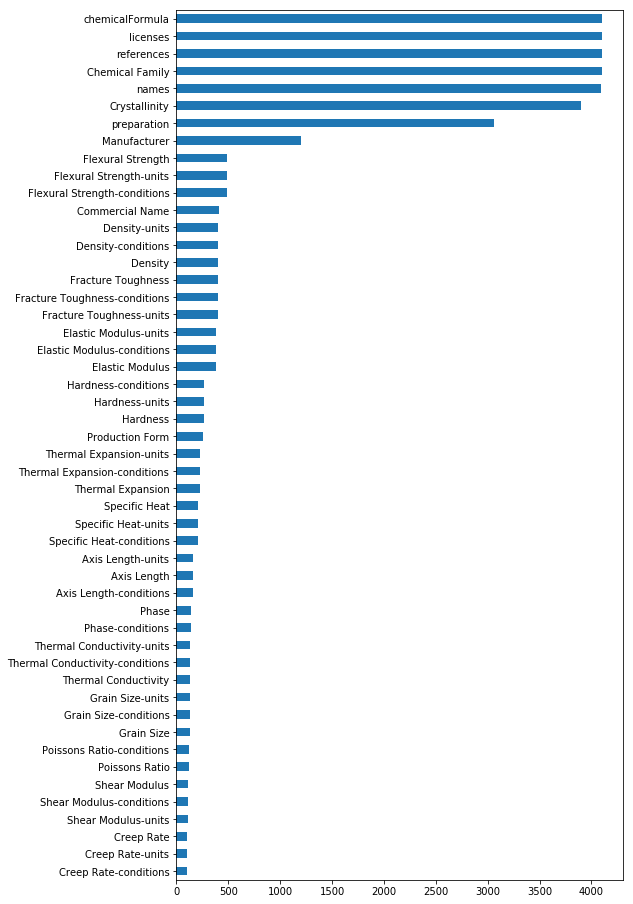

In [9]:
# Plot a bar chart showing the 50 most common features
plt.figure(figsize=(8,16))
df.count().sort_values()[-50:].plot.barh()
plt.show()

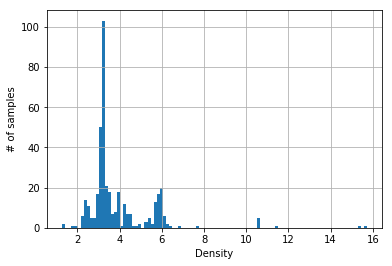

In [25]:
density = df['Density'].dropna()
density = pd.to_numeric(density, errors='coerce')
density.hist(bins=100)
plt.xlabel('Density')
plt.ylabel('# of samples')
plt.show()

# Featurization

In [26]:
# Create copy of original data to not mess with them
feat = df.copy()

### Make chemical formula compatible with pymatgen.core.composition

In [27]:
# Initialize composition column
feat['composition'] = feat['chemicalFormula']

In [28]:
# Check how many formulas cause an error when they are fed to pymatgen.core.composition (via str_to_composition)

N_errors, N_total = 0, 0
for entry in feat['composition']:
    try:
        pd.Series([entry]).transform(str_to_composition)
    except:
        N_errors +=1
        #print(entry)
    finally:
        N_total +=1

print('{0} errors in {1} samples'.format(N_errors, N_total))

1608 errors in 4098 samples


In [29]:
# This function removes certain characters and expressions from a chemical formula
# so that it can be converted using pymatgen.core.composition

def make_chem_form_compatible(formula):
    
    for bad_str in ['\.','x', 'y', '\+', '\-', 'z', 'w', '\%', '\^',   # individual characters
                 'Cordierite','hisker','Sialon', # certain words that show up in some formulas
                 '\$(.*?)\$',    # LaTeX expressions
                 '\((.*?)\)',    # bracketed expressions
                 '^\d{1,2}']:    # leading numbers of 1 or 2 digits
        formula = re.sub(bad_str, '', formula)
    
    return formula

In [30]:
# Convert chemical formulas using above function
feat["composition"] = feat["composition"].transform(make_chem_form_compatible)

# Converting chemical formula to composition object using
# matminer.utils.conversions.str_to_composition
# which in turn uses pymatgen.core.composition
feat["composition"] = feat["composition"].transform(str_to_composition)

In [31]:
feat['composition'].head()

1               (Si, O)
2    (Al, O, Si, Zr, Y)
3               (Al, O)
4     (Si, N, Ce, O, C)
5               (Si, N)
Name: composition, dtype: object

### Parse chemical formula
#### x, y, z, and w are setted to be 0.1 (can be modified)

In [32]:
df1 = df.copy()
df1.loc[3892,'chemicalFormula'] = 'BN' #fix 'B-N' to 'BN'

In [33]:
# Parse the chemicalFormula
def formula_decompose(formula):
    '''
    decompose chemical formula 
    return
        composition: list, [(element,num),...]
            element: string
            num: string, can be math expression such as '1+0.5x'
    '''

    comp = []
    p = re.compile(r'(\d?[w-z]?)([A-Z][a-u]?)(\d*\+?\-?\d*\.?\d*[w-z]?)')

    #split the chemical formula if there is dots, but not for cases like Mg1.5x
    if re.search(r'\.', formula) and not re.search(r'\d+\.\d[w-z]', formula): 
        formula = formula.split('.')
        for item in formula:
            prefactor = '1'
            for i in re.findall(p, item):
                pre, elem, num = i
                if pre:
                    prefactor = pre
                if num == '':
                    num = '1'
                num = prefactor + '*({})'.format(num)
                comp.append((elem, num))
    else:
        prefactor = '1'
        for i in re.findall(p, formula):
            pre, elem, num = i
            if pre:
                prefactor = pre
            if num == '':
                num = '1'
            num = prefactor + '*({})'.format(num)
            comp.append((elem, num))
    return comp 

def formula_reconstruct(composition, x=0.1, y=0.1, z=0.1, w=0.1):
    '''
    reconstruct chemical formula from composition
    composition in form of [(element,num), (element,num),...]
        element: string
        num: string, can be math expression such as '1+0.5x'

    return 
        flat chemcial formula: string, such as 'Ti1.5Cu0.1Au1.0'
    '''
    flat_list = []
    for (elem, num) in composition:
        num = re.sub(r'(\d)([w-z])', r'\1*\2', num) #convert 5x to 5*x
        flat_list.append(elem)
        flat_list.append(format(eval(num), '.1f'))
    return ''.join(flat_list)
  
def formula_parser(formula):
    return formula_reconstruct(formula_decompose(formula))

In [34]:
df1["flatFormula"] = df1["chemicalFormula"].map(formula_parser)
df1.dropna(axis=1).head()

,chemicalFormula,licenses,references,Chemical Family,flatFormula
1,SiO2,[{'name': 'NIST_SRD-30'}],"[{'citation': 'Gaseous Corrosion of Ceramics, ...",Si-O,Si1.0O2.0
2,3Al2O3.2SiO2.xZrO2.yY2O3,[{'name': 'NIST_SRD-30'}],[{'citation': 'Thermal Diffusivity/Conductivit...,Al-Si-O:ZrO,Al6.0O9.0Si2.0O4.0Zr0.1O0.2Y0.2O0.3
3,Al2O3,[{'name': 'NIST_SRD-30'}],"[{'citation': 'Mechanical Properties of Pure, ...",Al-O,Al2.0O3.0
4,Si3N4.xCeO2.ySiC,[{'name': 'NIST_SRD-30'}],[{'citation': 'Effect of Silicon Carbide Whisk...,Si-N:CeO,Si3.0N4.0Ce0.1O0.2Si0.1C0.1
5,Si3N4,[{'name': 'NIST_SRD-30'}],[{'citation': 'Corrosion of Silicon Nitride Ce...,Si-N,Si3.0N4.0


In [35]:
df1["composition"] =df1["flatFormula"].transform(str_to_composition)
df1.dropna(axis=1).head()

,chemicalFormula,licenses,references,Chemical Family,flatFormula,composition
1,SiO2,[{'name': 'NIST_SRD-30'}],"[{'citation': 'Gaseous Corrosion of Ceramics, ...",Si-O,Si1.0O2.0,"(Si, O)"
2,3Al2O3.2SiO2.xZrO2.yY2O3,[{'name': 'NIST_SRD-30'}],[{'citation': 'Thermal Diffusivity/Conductivit...,Al-Si-O:ZrO,Al6.0O9.0Si2.0O4.0Zr0.1O0.2Y0.2O0.3,"(Al, O, Si, Zr, Y)"
3,Al2O3,[{'name': 'NIST_SRD-30'}],"[{'citation': 'Mechanical Properties of Pure, ...",Al-O,Al2.0O3.0,"(Al, O)"
4,Si3N4.xCeO2.ySiC,[{'name': 'NIST_SRD-30'}],[{'citation': 'Effect of Silicon Carbide Whisk...,Si-N:CeO,Si3.0N4.0Ce0.1O0.2Si0.1C0.1,"(Si, N, Ce, O, C)"
5,Si3N4,[{'name': 'NIST_SRD-30'}],[{'citation': 'Corrosion of Silicon Nitride Ce...,Si-N,Si3.0N4.0,"(Si, N)"


In [36]:
#check the composition object
df1.loc[4,'composition']

Comp: Ce0.1 Si3.1 C0.1 N4 O0.2

### Featurize with matminer

In [37]:
df1.shape

(4098, 163)

In [38]:
df1_feat = df1.copy()

In [39]:
# Add new features to df_feat
ep_feat = ElementProperty.from_preset(preset_name="magpie")
df1_feat = ep_feat.featurize_dataframe(df1_feat, col_id="composition", ignore_errors=True)

In [40]:
df1_feat.shape

(4098, 295)

In [41]:
# List of the new columns
list(set(df1_feat.columns) ^ set(df1))

['range AtomicWeight',
 'minimum NsUnfilled',
 'maximum GSbandgap',
 'maximum NfUnfilled',
 'maximum CovalentRadius',
 'mean Column',
 'minimum MeltingT',
 'minimum NUnfilled',
 'avg_dev NUnfilled',
 'maximum AtomicWeight',
 'range GSmagmom',
 'mean NUnfilled',
 'maximum GSmagmom',
 'maximum NpUnfilled',
 'range Row',
 'minimum NfUnfilled',
 'mode AtomicWeight',
 'mode Electronegativity',
 'minimum GSvolume_pa',
 'mode SpaceGroupNumber',
 'mean Electronegativity',
 'mean MendeleevNumber',
 'minimum NdUnfilled',
 'mean CovalentRadius',
 'range NfUnfilled',
 'maximum Column',
 'maximum NdUnfilled',
 'mode GSvolume_pa',
 'avg_dev NdUnfilled',
 'range NpUnfilled',
 'maximum NfValence',
 'mean GSvolume_pa',
 'mean SpaceGroupNumber',
 'avg_dev NpValence',
 'mode Column',
 'mean Row',
 'avg_dev Electronegativity',
 'avg_dev SpaceGroupNumber',
 'range SpaceGroupNumber',
 'mode Row',
 'range MeltingT',
 'minimum NfValence',
 'minimum Row',
 'mode NValence',
 'range CovalentRadius',
 'mean NdUnf

In [42]:
df1_feat['avg_dev MeltingT'].head()

1    725.422222
2    516.580380
3    421.761600
4    823.174827
5    795.404082
Name: avg_dev MeltingT, dtype: float64